# Choroshape Census Data Examples

This script makes county-level choropleth maps that represent the amount of women of reproductive age (defined here as females 15 to 49) by proportion of county population for several U.S. states. This script demostrates one way to use Choroshape to make chorepleth maps. The script uses data from census pep API and Tiger shapefiles also from the U.S. Census site.

In [19]:
import choroshape as cshp
import datetime as dt
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import us
import json
import io
import zipfile
from six.moves.urllib.request import urlopen

Sets up some variables. A census api key must be specified here, as must the output path for storing the map image files.

In [20]:
TODAY = dt.datetime.today().strftime("%m/%d/%Y")
OUTPATH = os.path.expanduser('~/Desktop/Example_Files/')
MYTOKEN =  # Get your census api key at http://api.census.gov/data/key_signup.html

This function reads in the data from the census api and returns a pandas dataframe.

In [21]:
def census_call(url):
    '''Calls a table from the census API and creates a pandas DataFrame
    Args:
        url(str): complete url to use for the call, alread has the table_code.
            Examples can be found ont the Census API guide.
    Returns:
        df(pd.DataFrame): data in DataFrame format'''
    response = urlopen(url)
    str_response = response.read().decode('utf-8')
    data = json.loads(str_response)
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

Here a dictionary is created to store slightly different style specifications for each state. Custom style can be specified through the Choroshape.ChoroplethStyle object.

In [22]:
style_dict = {}
style_dict['MA'] = choroshape.ChoroplethStyle(county_colors='blues', legx=.07,
                                              legy=0.18, ttlx=.08, ttly=0.9)
style_dict['MI'] = choroshape.ChoroplethStyle(county_colors='greens', legx=.07,
                                              legy=0.18, ttlx=.08, ttly=0.9)
style_dict['TX'] = choroshape.ChoroplethStyle(county_colors='violets', legx=.07,
                                              legy=0.18, ttlx=.08, ttly=0.9)
style_dict['NC'] = choroshape.ChoroplethStyle(county_colors='reds', legx=.07,
                                              legy=0.18, ttlx=.08, ttly=0.9)
style_dict['CO'] = choroshape.ChoroplethStyle(county_colors='oranges',legx=.07,
                                              legy=.12, ttlx=.08, ttly=0.84)

In [23]:
print('Is this working?')

Is this working?


Here the script is looping over the states in the style_dict and
1. Finding the specified data table
2. Filter and clean the data
3. Find the total population for each county
4. Find the total number of women age 15 to 49 for each county
5. Downloads the shapefile
6. Creates and cleans a geodataset
7. Creates an area population data object
8. Creates a style object
9. Creates a choropleth object
10. Plots the map

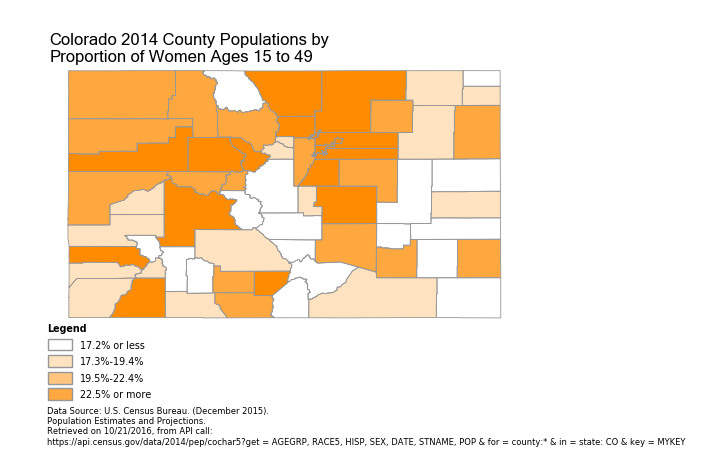

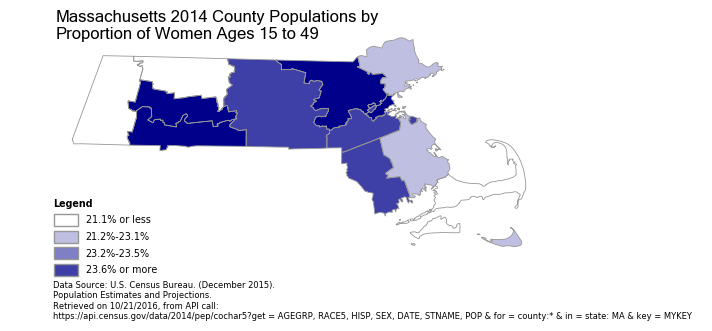

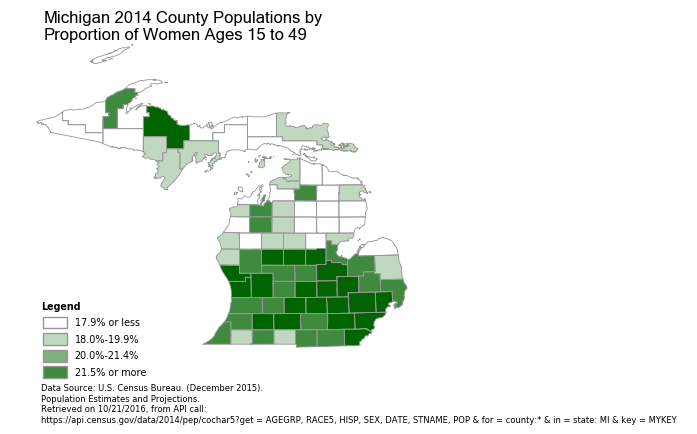

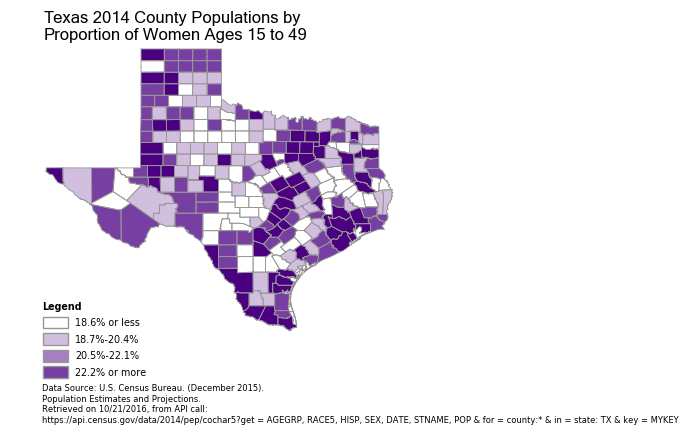

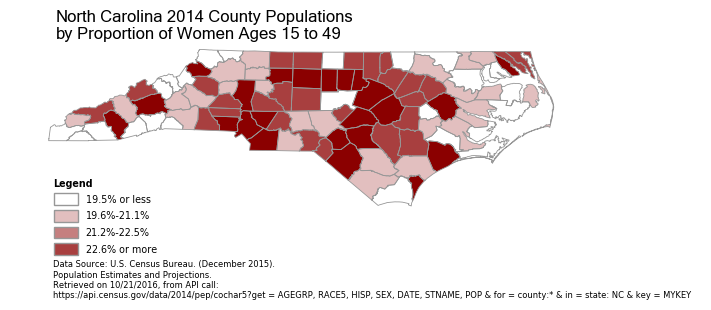

In [25]:
states = [key for key in style_dict]
for state in states:
    
    # Get the state info using the us library
    state_fips = us.states.lookup(state).fips
    state_name = us.states.lookup(state).name

    # Get the data table from the census api and crate a datagrame
    url = 'https://api.census.gov/data/2014/pep/cochar5?get=AGEGRP,RACE5,' +\
        'HISP,SEX,DATE,STNAME,POP&for=county:*&in=state' +\
        ':%s&key=%s' % (state_fips, MYTOKEN)
    df = census_call(url)

    # Filter and clean the data
    df = cshp.fix_FIPS(df, 'county', 'state')
    df['POP'] = df['POP'].str.strip().astype(int)
    df = df[df['DATE'] == '6']  # filter to 2014

    # Get the total for each county; here the age group zero is all ages
    total = df[(df['AGEGRP'] == '0')]   # All ages
    total = total.groupby(['FIPS'], as_index=False).aggregate(np.sum)

    # Get the total for each county for women in the specified age group
    df = df[df['SEX'] == '2']  # Women
    df = df[(df['AGEGRP'] == '4') | (df['AGEGRP'] == '5') | (
        df['AGEGRP'] == '6') | (df['AGEGRP'] == '7') | (
        df['AGEGRP'] == '8') | (df['AGEGRP'] == '9') | (
        df['AGEGRP'] == '10')]  # 15 to 49
    df = df.groupby(['FIPS'], as_index=False).aggregate(np.sum)
    
    # Calculate a ratio here; Choroshape can also automatically calculate a ratio
    df.rename(columns={'POP': 'female_15_to_49'}, inplace=True)
    df = pd.merge(left=df, right=total, how='left', on='FIPS')
    df['ratio'] = df['female_15_to_49'].astype(float)/df['POP']
    
    # Download the shapefile info for the state
    remotezip = urlopen('http://www2.census.gov/geo/tiger/' +\
                               'GENZ2014/shp/cb_2014_us_county_500k.zip')
    zipinmemory = io.BytesIO(remotezip.read())
    z = zipfile.ZipFile(zipinmemory)
    fn_path = os.path.normpath('%sshapefiles/' % OUTPATH)
    z.extractall(fn_path)
    bordersfn = os.path.join(fn_path, 'cb_2014_us_county_500k.shp')

    # Creates a geodataframe
    geodf = gpd.GeoDataFrame.from_file(bordersfn)
    geodf = (geodf[geodf['STATEFP'] == state_fips])
    geodf = cshp.fix_FIPS(geodf, 'COUNTYFP', 'STATEFP')

    # Footnote for the map
    footnote = 'Data Source: U.S. Census Bureau. (December 2015).\n    ' +\
               'Population Estimates and Projections.\n    ' +\
               'Retrieved on %s, from API call:\n    ' % TODAY +\
               'https://api.census.gov/data/2014/pep/cochar5?get = AGEGRP, ' +\
               'RACE5, HISP, SEX, DATE, STNAME, POP & for = county:*' +\
               ' & in = state: % s & key = MYKEY' % state
    
    # Creates a dataset object using the Choroshape defaults
    apd = cshp.AreaPopDataset(df, geodf, 'FIPS', 'FIPS',
                         cat_col='ratio',
                         footnote=footnote,
                         cat_name=state + '_Female_15_to_49',
                         title=state_name + ' 2014 County Populations by Proportion of Women Ages 15 to 49',
                         percent_format=True)
    
    # Creates a chstyle object
    chstyle = style_dict[state]
    
    # Creates the map
    chmap = cshp.Choropleth(apd, chstyle, None, OUTPATH, True, True)
    
#     Plots the map
    chmap.plot()